In [1]:
from scipy.stats import binom
from scipy.special import binom as ncr
from scipy.misc import factorial
from __future__ import division
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import merge_alg
sys.path.append('../common')
import common_probs
from sampler import DepthSampler
sys.path.append('../aho_merging')
from failure_tree import FailureTree
import arbitrary_probs_util as string_util
import markov_signature_size

#### Note:
Changing signatures to include the current depth so root node has signature $(0)$, state in depth 1 has signature $(0, 1)$, etc.

# MultiType Branching

For this, I explore possibilities of multitype branching but with merging included. First, we focus just on the multitype branching part. Let $Z_k$ be a vector representing the number of states a depth $k$ of the DFA. In particular, the $i^{th}$ index of the vector is the number of signatures with size $i + 1$. On top of this, let $Y_{i, j}$ be a vector representing the offspring of state $j$ with $i + 1$ elements in the signature. Overall we have...

$$
Z_k = \sum_{i = 1}^{n}\sum_{j=1}^{Z_{i, (k -1)}} Y_{i, j}
$$

With some quick math and assumption of independence we can show that...

$$
u_k = u_{k - 1} M \implies u_k = u_0 M^k
$$

Where $u_k := E[Z_k]$ and $m_{i, j} = E[Z_{j,1} | Z_0 = e_i]$ for $i, j \in \{1, \ldots, n\}$. In other words, $M$ is the matrix that contains expected one step information. While the true $M$ may be very hard to form and may not even be feasible (because right now we are assuming that things are depth homogenous), there is a simple $M$ that would could use for an upper bound.

For row $1 \leq i < n$ of the matrix we can have the probabilities distributed as a $Binomial(i, c_2) + 1$. This will be the same for the last row, however, we are short one column so combine the last two columns. The intuition behind doing this comes from the fact that given some parent signature, the child's signature can only have the elements of the parents signature plus 1 (and also 0). It makes sense that to add one to one of the parent signature terms the probability should be $c_2$ (the probability of two sets overlapping). Thus we get a binomial for the amount of terms in the child's signature.

# Adding in Merging

With this established we would like to now add in merging. Assume that in some current depth we know that we have expanded $b$ states of a certain type. Furthermore, we know that there are only $u$ possible signatures that can be taken for each of the states. We want to know how many unique signatures there are in the expanded states then. This can be thought of as the urn and ball problem where given $u$ urns and $b$ balls, we want to know how many urns have at least one ball in them.

For simplicity, assume that we are able to throw each ball into an urn with equal probability. This will result in an upper bound since it is less likely that an urn has multiple balls (thus we will merge less). This probability has been previously found. In particular where $x$ is the number of states remaining after we merge...

$$
P(X_{u, b} = x) = nCr(u, x) * S(b, x) * \frac{1}{x!} \left(\frac{1}{u}\right)^b
$$

Here $S(n,k)$ is the Stirling number of the second kind which represents the number of ways to partition a set of n objects into k non-empty subsets (https://en.wikipedia.org/wiki/Stirling_numbers_of_the_second_kind). The goal is then to find the expected amount of merging index of the offspring vector ($Z_k$).

$$
E[X_{u, b} | b = Z_k]
$$

Here $u$ for the equation at index $i$ is $u = nCr(n, i)$. The final goal is then to find

$$
E[E[X_{u, b} | b = Z_k]]
$$

Which is what I attempted below...

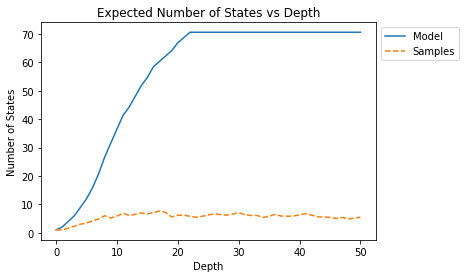

Previous best upper bound limit: 48518.561241


In [26]:
# Monte Carlo to test expected value expression.

MAX_DEPTH = 50
MAX_SIG_DEPTH = 10
PROBS = [0.5 for _ in range(4)]
SAMPLES = 100

c_2 = common_probs.get_arbitrary_c2(PROBS)

# The expected values of the offspring types should just be
# the probability they happen from a binomial.
exp_y = np.zeros((MAX_SIG_DEPTH, MAX_SIG_DEPTH))
for row in xrange(MAX_SIG_DEPTH):
    b_dist = binom(row + 1, c_2)
    for col in xrange(row + 2):
        if col >= MAX_SIG_DEPTH:
            col = MAX_SIG_DEPTH - 1
        exp_y[row, col] += b_dist.pmf(col)

def simulate():
    sizes = []
    curr = np.zeros((1, MAX_SIG_DEPTH))
    curr[0,0] = 1
    for _ in xrange(MAX_DEPTH):
        sizes.append(np.sum(curr))
        curr = find_next(curr)
    sizes.append(np.sum(curr))
    return sizes
        
def find_next(last_expected):
    next_output = np.dot(last_expected, exp_y)
    merged_vec = np.zeros(next_output.shape)
    for i in xrange(next_output.shape[1]):
        merged_vec[0, i] = expected_merge(next_output[0, i], i + 1)
    return merged_vec

merge_cache = {}
def expected_merge(output, sig_size):
    if (output, sig_size) in merge_cache:
        return merge_cache[(output, sig_size)]
    urns = ncr(MAX_SIG_DEPTH, sig_size)
    expected = 0
    out_int = int(np.ceil(output))
    prob = (1 / urns) ** out_int
    for y in xrange(1, out_int + 1):
        expected += y * ncr(urns, y) * stirling_numerator(out_int, y) * prob
    merge_cache[(output, sig_size)] = expected
    return expected
    
def stirling_numerator(a, b):
    to_return = 0
    for j in xrange(b + 1):
        to_return += (-1) ** (b - j) * ncr(b, j) * j ** a
    return to_return

# Sample from algorithm
ds = DepthSampler(PROBS, MAX_DEPTH)
df = ds.draw_samples(SAMPLES, ['states'])
sample_sizes = df.groupby('depth')['states'].mean()

# Plot
sizes = simulate()
plt.plot(range(MAX_DEPTH + 1), sizes, label='Model')
plt.plot(range(MAX_DEPTH + 1), sample_sizes, '--', label='Samples')
plt.xlabel('Depth')
plt.ylabel('Number of States')
plt.title('Expected Number of States vs Depth')
plt.legend(bbox_to_anchor=[1,1])
plt.show()

print 'Previous best upper bound limit: %f' % (2 ** (np.log(MAX_DEPTH) / np.log(1 / c_2)))

### Some notes on this...

* This seems to work! Much better upper bound than before.

* Flattens out sharply and very suddenly implying that maybe we can find a fixed point of this equation. This would make things easy to show that they converge. However, there will be a lot of difficult math to do this.

# Failure Tree

Perhaps it would be better to analyze the failure tree. That is the tree that is made by only considering the failure transitions. You can prove that this is indeed a tree using the fact that any state only has one failure. Below, I did simulations of this failure tree and plotted the size of the failure trees depth. One can see most of the tree is concentrated in the lower depths.

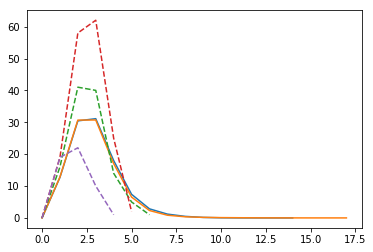

In [8]:
PROBS = [0.5 for _ in range(4)]
SIMULATIONS = 1000
LENGTH = 20

# Simulate trees to find the size of the tree depth.
alph = string_util.get_default_alphabet(len(PROBS))
depth_avgs = []
samples = []
for _ in xrange(SIMULATIONS):
    g = string_util.create_random_string(PROBS, LENGTH)
    dfa = merge_alg.aho_merge(g, alph)
    ft = FailureTree(dfa.root)
    if len(samples) < 3:
        samples.append(ft.depth_sizes)
    while len(ft.depth_sizes) >= len(depth_avgs):
        depth_avgs.append(0)
    for ind, s in enumerate(ft.depth_sizes):
        depth_avgs[ind] += s
for i in range(len(depth_avgs)):
    depth_avgs[i] /= SIMULATIONS
    
plt.plot(range(len(depth_avgs)), depth_avgs)
for s in samples:
    plt.plot(range(len(s)), s, '--')
plt.show()

# Failure Tree Modelling

In order to attempt modelling the failure tree, consider the Markov chain discussed earlier in which we can find the probability of a given signatures size given the depth in the tree. The ptm for this is just the $M$ matrix used above. 

Consider $F_k$ which is the number of nodes in depth $k$ of the failure tree. One lower bound could then be...

$$
F_k \geq \sum_{i = 1}^{n} \mathbb{1}[\textrm{Depth $i$ in DFA has signature of size $k + 1$}]
$$

This is a lower bound because there could be multiple signatures of size $k + 1$ in depth $i$. Let $F = \sum F_k$ (i.e. size of the entire tree). Note then that...

$$
F \geq || \sum_{j = 0}^n e_0^T M^j ||_1
$$

By doing this in matrix form we compute each $F_k$ at once and then do the 1 norm to compute F. While this lower bound captures the correct shape of the distribution, it is not tight enough to be useful. Overall, it seems quite hard to model how many states are in the tree.

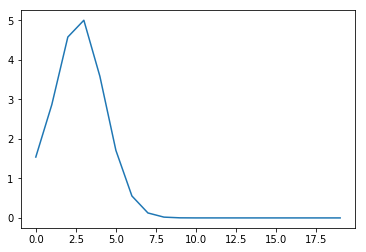

In [2]:
# Find the expected failure tree depth sizes with the Markov Model.

PROBS = [0.5 for _ in range(4)]
DEPTH = 20

c_2 = common_probs.get_arbitrary_c2(PROBS)

sizes = markov_signature_size.expected_sizes(c_2, DEPTH)
plt.plot(range(len(sizes[0])), sizes[0])
plt.show()

This seems to be the exact right shape we need. Just needs to be scaled by some factor so that we have the 